<a href="https://colab.research.google.com/github/victorviro/ML_algorithms_python/blob/master/Ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble learning

Suppose you ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*, and an Ensemble Learning algorithm is called an *Ensemble method*.


For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a *Random Forest*, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

Moreover, you will often use Ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in Machine Learning competitions often involve several Ensemble methods.

In this article we will discuss the most popular Ensemble methods, including *bagging*, *boosting*, *stacking*, and a few others. We will also explore Random Forests.

## Voting classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1).

![texto alternativo](https://i.ibb.co/BtbmBzY/ensemble.png)

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a *hard voting* classifier (see Figure 7-2).

![texto alternativo](https://i.ibb.co/7N6xpDk/hard-voting-classifie.png)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a $51$% chance of coming up heads, and $49$% chance of coming up tails. If you toss it $1000$ times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after $1000$ tosses is close to $75$%. The more you toss the coin, the higher the probability. This is due to the [*law of large numbers*](https://en.wikipedia.org/wiki/Law_of_large_numbers): as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads ($51$%). The next figure shows $10$ series of biased coin tosses. 

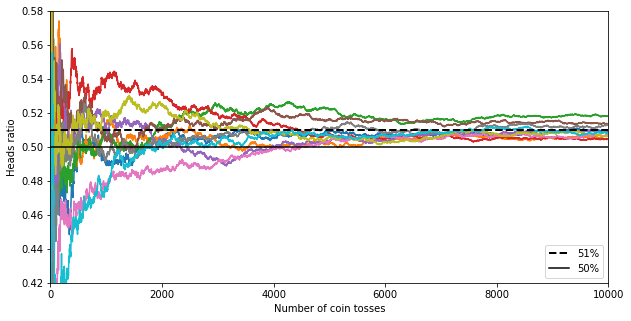

In [34]:
#@title
import numpy as np
import matplotlib.pyplot as plt

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

You can see that as the number of tosses increases, the ratio of heads approaches $51$%. Eventually all 10 series end up so close to $51$% that they are consistently above $50$%.

Similarly, suppose you build an ensemble containing $1000$ classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to $75$% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

Thus, ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset):

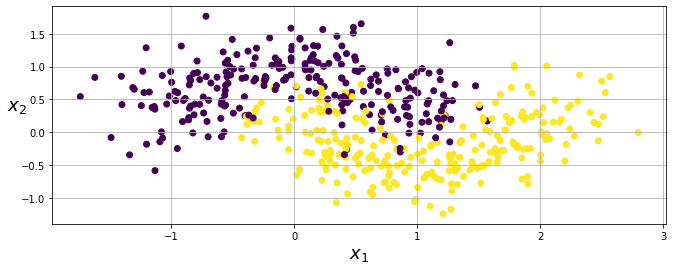

In [35]:
#@title
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

plt.figure(figsize=(11, 4))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

Let’s look at each classifier’s accuracy on the test set:

In [37]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


The voting classifier slightly outperforms all the individual classifiers.


If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace `voting="hard"` with `voting="soft"` and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its `probability` hyperparameter to `True` (this will make the `SVC` class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method).

In [38]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42) 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


The voting classifier achieves over $91.2$% accuracy!

## Bagging and pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed *with* replacement, this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed *without* replacement, it is called *pasting*.

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor. This sampling and training process is represented in Figure 7-4.

![texto alternativo](https://i.ibb.co/PWjsb9M/bagging-pasting.png)

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation function is typically the *statistical mode* (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.


As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.


#### The Bias-variance tradeoff



The [Bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) an important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

- *Bias*: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

- *Variance*: This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

- *Irreducible error*: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).


Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

### Bagging and pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of $500$ Decision Tree classifiers, each trained on $100$ training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`). The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (`n_jobs=-1` tells Scikit-Learn to use all available cores):

In [39]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


**Note**: The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities, which is the case with Decision Trees classifiers.

The next figure compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. 


In [40]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


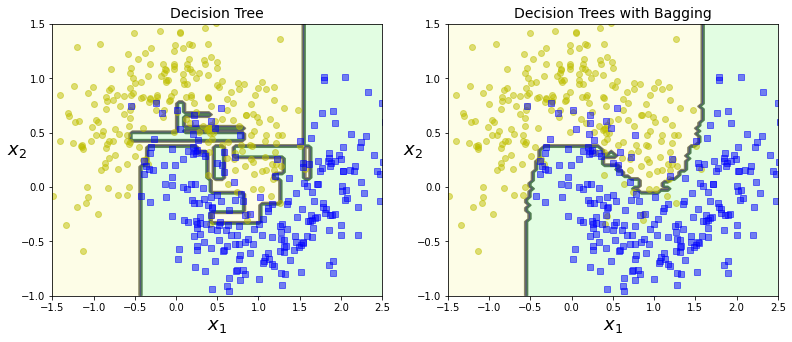

In [41]:
#@title
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(13,5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).


Bootstrapping (resampling with replacement) introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a `BaggingClassifier` samples $m$ training instances with replacement ( `bootstrap=True`), where $m$ is the size of the training set. This means that only about $63$% of the training instances are sampled on average for each predictor. The remaining $37$% of the training instances that are not sampled are called *out-of-bag* (oob) instances. Note that they are not the same $37$%
for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.


In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the `oob_score_` variable:

In [42]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, random_state=40,
    oob_score=True
)
bag_clf.fit(X_train, y_train)

print(bag_clf.oob_score_)

0.9013333333333333


According to this oob evaluation, this `BaggingClassifier` is likely to achieve about $90.1$% accuracy on the test set. Let’s verify this:

In [43]:
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


We get $91.2$% accuracy on the test set.

The oob decision function for each training instance is also available through the `oob_decision_function_` variable. In this case (since the base estimator has a `predict_proba()` method) the decision function returns the class probabilities for each training instance. For example, the oob evaluation estimates that the first training instance has a $68.25$% probability of belonging to the positive class (and $31.75$% of belonging to the negative class):

In [44]:
bag_clf.oob_decision_function_[0:1]

array([[0.31746032, 0.68253968]])

## Random patches and random subspaces

The `BaggingClassifier` class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features` . They work the same way as `max_samples` and `bootstrap` , but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.


This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the [*Random Patches*](https://www.semanticscholar.org/paper/Ensembles-on-Random-Patches-Louppe-Geurts/f5ae0b1b48a21ae9083f670d7043495f067064e4?p2df) method. Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than $1.0$) is called the *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier` , you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees 10 (similarly, there is a `RandomForestRegressor` class for regression tasks). The following code trains a Random Forest classifier with $500$ trees (each limited to maximum $16$ nodes), using all available CPU cores:

In [45]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.912


With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself. The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [46]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42), n_estimators=500,
    max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42,
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))  # 0.92

0.92


In [47]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

### Extra-trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).


A forest of such extremely random trees is simply called an [*Extremely Randomized Trees*](https://link.springer.com/article/10.1007/s10994-006-6226-1) ensemble (or *Extra-Trees* for short). Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.


You can create an Extra-Trees classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

**Note**: It is hard to tell whether a `RandomForestClassifier`
will perform better or worse than an `ExtraTreesClassifier`. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

### Feature importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.


Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to $1$. You can access the result using the `feature_importances_` variable. For example, the following code trains a `RandomForestClassifier` on the iris dataset and outputs each feature’s importance.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


It seems that the most important features are the petal length ($44$%) and width ($42$%), while sepal length and width are rather unimportant in comparison ($11$% and $2$%, respectively).

Similarly, if we train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, we get the image represented in the next
figure.





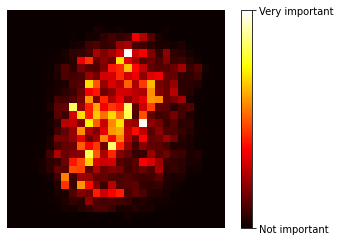

In [49]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

rnd_clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])


def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')


plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

## Boosting

*Boosting* refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for *Adaptive Boosting*) and *Gradient Boosting*.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.


For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on (see Figure 7-7).

![texto alternativo](https://i.ibb.co/zHhX6Q2/adaBoost.png)

Figure 7-8 shows the decision boundaries of five consecutive predictors on the
moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel ). 




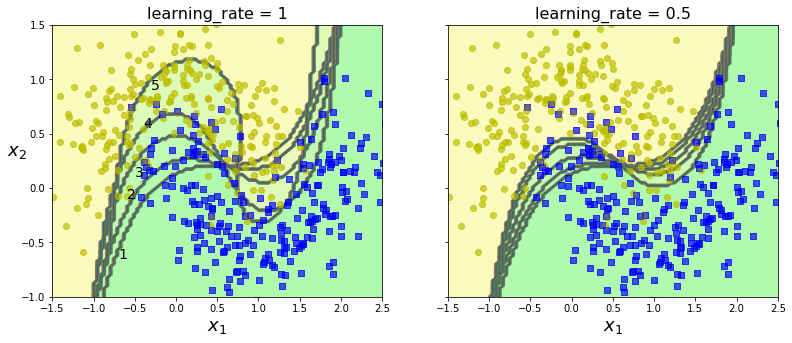

<Figure size 936x360 with 0 Axes>

In [50]:
#@title
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)
fix, axes = plt.subplots(ncols=2, figsize=(13,5), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")    
plt.figure(figsize=(13,5))
plt.show()

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with[ Gradient Descent](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_gradient_descent_algorithm.ipynb), except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.


**Note**:There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bagging or pasting.


Let’s take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$ . A first predictor is trained and its weighted error rate $r_1$ is computed on the training set; see Equation 7-1.

$$r_j=\frac{\sum_{\substack{
i=1 \\
\hat{y}_j^{(i)} \neq y_j^{(i)}
}}^{m} w^{(i)}}{\sum_{i=1}^{m}w^{(i)}}$$

- $\hat{y}_j^{(i)}$ is the $j^{\text{th}}$ predictor’s prediction for the $i^{\text{th}}$ instance.

The predictor’s weight $\alpha_j$ is then computed using the next equation:

$$\alpha_j = \eta log\frac{1-r_j}{r_j}$$

- $\eta$ is the learning rate hyperparameter (defaults to 1) (the original AdaBoost algorithm does not use a learning rate hyperparameter).

The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.



Next the misclassified instances are boosted, this is, if $\hat{y}_j^{(i)} \neq y_j^{(i)} $ the instance weights are updated using the equation: 

$$w^{(i)} = w^{(i)} e^{\alpha_j}, i=1,...,m $$

Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^{m}w^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes:

$$\hat{y}(\boldsymbol{x})=\text{arg}\max\limits_{k}\sum_{\substack{
j=1 \\
\hat{y}_j (\boldsymbol{x}) = k
}}^{N} \alpha_j$$

- $N$ is the number of predictors.

Scikit-Learn actually uses a multiclass version of AdaBoost called [SAMME](https://www.intlpress.com/site/pub/pages/journals/items/sii/content/vols/0002/0003/a008/) (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.


The following code trains an AdaBoost classifier based on $200$ Decision Stumps using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an `AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1`, in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

In [51]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200,
algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, algorithm='SAMME.R', random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

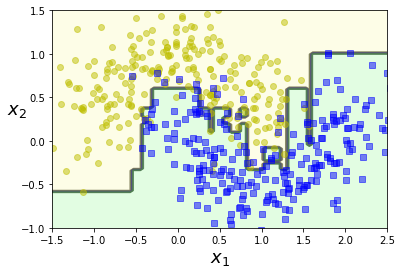

In [53]:
plot_decision_boundary(ada_clf, X, y)
plt.show()

**Note**: If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing the base estimator.

### Gradient boosting

Another very popular Boosting algorithm is *Gradient Boosting*. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.


Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with classification tasks). This is called *Gradient Tree Boosting*, or *Gradient Boosted Regression Trees* (GBRT). First, let’s fit a `DecisionTreeRegressor` to the training set (for example, a noisy quadratic training set):

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [55]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [56]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [57]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


The next figure represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. 

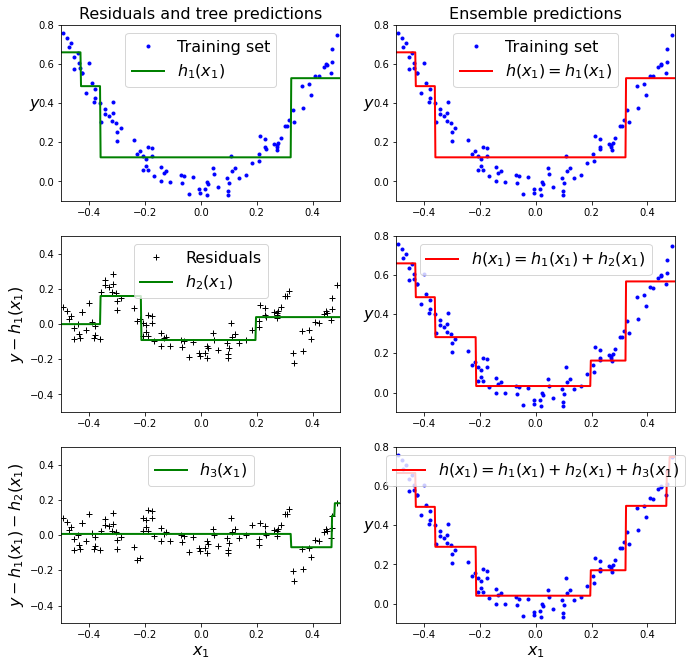

In [58]:
#@title
def plot_predictions(regressors, X, y, axes=[-0.5, 0.5, -0.1, 0.8], label=None, style='r-', data_style='b.', data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)

    plt.plot(X, y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)


plt.figure(figsize=(11, 11))
plt.subplot(321)
plot_predictions([tree_reg1], X, y, label='$h_1(x_1)$', style='g-', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Residuals and tree predictions', fontsize=16)
plt.subplot(322)
plot_predictions([tree_reg1], X, y, label='$h(x_1) = h_1(x_1)$', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Ensemble predictions', fontsize=16)
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_2(x_1)$', style='g-', data_style='k+', data_label='Residuals')
plt.ylabel('$y - h_1(x_1)$', fontsize=16)
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, label='$h(x_1) = h_1(x_1) + h_2(x_1)$')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_3(x_1)$', style='g-', data_style='k+')
plt.ylabel('$y - h_1(x_1) - h_2(x_1)$', fontsize=16)
plt.xlabel('$x_1$', fontsize=16)
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, label='$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.xlabel('$x_1$', fontsize=16)
plt.show()

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.


A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth` , `min_samples_leaf` , and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`). The following code creates the same ensemble as the previous one:

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_new = np.array([[0.8]])

gbrt = GradientBoostingRegressor(learning_rate=1.0, n_estimators=3, max_depth=2)
gbrt.fit(X, y)
print(gbrt.predict(X_new)) 

[0.75026781]


The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as $0.1$ , you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*. The next figure shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

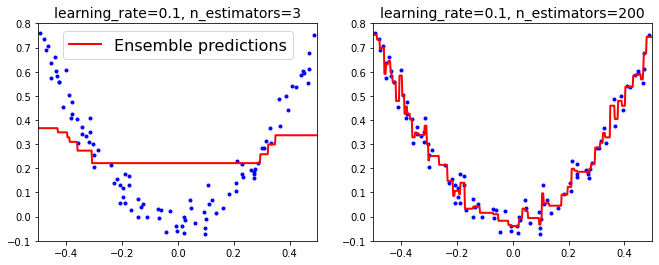

In [60]:
#@title
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=0.1, 
    random_state=42)

gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42)

gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions(
    [gbrt], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8], 
    label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions(
    [gbrt_slow], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

# left: not enough trees (underfits)
# right: too many trees (overfits)

In order to find the optimal number of trees, you can use [early stopping](https://en.wikipedia.org/wiki/Early_stopping) (basically, stop training as soon as the validation error reaches a minimum.). A simple way to implement this is to use the `staged_predict()` method: it
returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with $120$ trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

# train GRBR regressor with 120 trees

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# measure MSE validation error at each stage
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

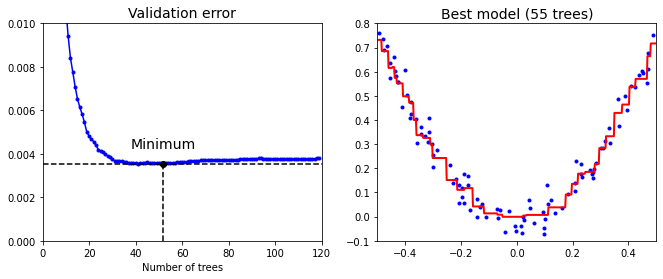

In [62]:
# train another GBRT ensemble using optimal #trees

best_n_estimators = np.argmin(errors)
min_error = errors[best_n_estimators]

gbrt_best = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=best_n_estimators, 
    learning_rate=0.1, 
    random_state=42)

gbrt_best.fit(X_train, y_train)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=79, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (55 trees)", fontsize=14)
plt.show()

The validation errors are represented on the left of the previous figure, and the best model’s predictions are represented on the right.


It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting `warm_start=True` , which makes Scikit-Learn keep existing trees when the `fit()` method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:


In [63]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

# 120 estimators.
# stop training with validation error doesn't improve for five consecutive iterations
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

47
Minimum validation MSE: 0.003554071291988297


The `GradientBoostingRegressor` class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on $25$% of the training instances, selected randomly. As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called *Stochastic Gradient Boosting*.

**Note**: It is possible to use Gradient Boosting with other cost functions.
This is controlled by the loss hyperparameter (see Scikit-Learn’s
documentation for more details).


It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library [XGBoost](https://github.com/dmlc/xgboost), which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep)
Machine Learning Community (DMLC), and it aims at being extremely fast, scalable and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [64]:
import xgboost
xgb_reg = xgboost.XGBRegressor(objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.0037664172987913937


XGBoost also offers several nice features, such as automatically taking care of early stopping:

In [65]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)  

[0]	validation_0-rmse:0.264628
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.238158
[2]	validation_0-rmse:0.213671
[3]	validation_0-rmse:0.191839
[4]	validation_0-rmse:0.173536
[5]	validation_0-rmse:0.15676
[6]	validation_0-rmse:0.142701
[7]	validation_0-rmse:0.130993
[8]	validation_0-rmse:0.119751
[9]	validation_0-rmse:0.11102
[10]	validation_0-rmse:0.103301
[11]	validation_0-rmse:0.096759
[12]	validation_0-rmse:0.090696
[13]	validation_0-rmse:0.085071
[14]	validation_0-rmse:0.080967
[15]	validation_0-rmse:0.076923
[16]	validation_0-rmse:0.073651
[17]	validation_0-rmse:0.070516
[18]	validation_0-rmse:0.067908
[19]	validation_0-rmse:0.065979
[20]	validation_0-rmse:0.064584
[21]	validation_0-rmse:0.063215
[22]	validation_0-rmse:0.062086
[23]	validation_0-rmse:0.061187
[24]	validation_0-rmse:0.060842
[25]	validation_0-rmse:0.060447
[26]	validation_0-rmse:0.060134
[27]	validation_0-rmse:0.059679
[28]	validation_0-rmse:0.059234
[29]	validation_0-rm

## Stacking

The last Ensemble method we will discuss is called *stacking* (short for [stacked generalization](http://machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf)). It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? Figure 7-12 shows such an ensemble performing a regression task on a new instance.

![texto alternativo](https://i.ibb.co/YXGKJ0s/blending-predictor.png)

Each of the bottom three predictors predicts a different value ($3.1$, $2.7$, and $2.9$), and then the final predictor (called a *blender*, or a *meta learner*) takes these predictions as inputs and makes the final prediction ($3.0$).

To train the blender, a common approach is to use a hold-out set. Let’s see how it works. First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer (see Figure 7-13).

![texto alternativo](https://i.ibb.co/c2ZbKdW/training-stacking.png)


Next, the first layer predictors are used to make predictions on the second (held-out) set (see Figure 7-14).

![texto alternativo](https://i.ibb.co/Vwtyz8F/training-stacking2.png)

This ensures that the predictions are “clean,” since the predictors never saw these instances during training. Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value given the first layer’s predictions.

**Note**: It is possible to use out-of-fold predictions. In some contexts this is called *stacking*, while using a hold-out set is called *blending*. However, for many people these terms are synonymous.


It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in Figure 7-15.

![texto alternativo](https://i.ibb.co/dDL2rm6/multilayer-stacking.png)

Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation. Alternatively, you can use an open source implementation such as [DESlib](https://github.com/scikit-learn-contrib/DESlib).


